<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Explicación de Predicciones: Variables más Importantes en Random Forest</h1> </div>

Desarrollado por: Ing. Remigio Hurtado Ortiz, PhD. Correo de contacto: remigiohurtado@gmail.com

En este ejemplo práctico se desarrolla varios métodos mediante pipelines y posteriormente se identifican las variables más importantes del modelo Random Forest entrenado para explicar las predicciones.

Estructura:

- [Carga y análisis del Dataset](#Carga-analisis-inicial)

- [Desarrollo de métodos mediante Pipelines](#Desarrollo-metodos)

- [Explicación de variables importantes](#Explicacion)

<div id="Carga-analisis-inicial" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Carga y análisis del Dataset</h2> </div>

<div id="Importacion" style="color:#106ba3"><h3>Importación de librerías y definición de funciones</h3> </div>

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# to persist the model and the scaler
import joblib

# ========== NEW IMPORTS ========
# Respect to notebook 02-Predicting-Survival-Titanic-Solution

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

# for imputation
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)

# for encoding categorical variables
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder
)

print('Módulos importados')

Módulos importados


In [2]:
# Función para medir la calidad de modelos
def obtenerResultados(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    accuracy=str(round(accuracy, 4))
    precision=str(round(precision, 4))
    recall=str(round(recall, 4))
    f1=str(round(f1, 4))
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall o Sensitivity:", recall)
    print("F1-Score:", f1)
    return accuracy, precision, recall, f1

def train_test_metrics(pipe):
    # make predictions for train set
    print('Resultados en Train:')
    y_pred = pipe.predict(X_train)
    obtenerResultados(y_train, y_pred)

    # make predictions for test set
    print('\nResultados en Test:')
    y_pred = pipe.predict(X_test)
    obtenerResultados(y_test, y_pred)

Funciones para guardar y cargar modelos personalizados


In [3]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

# URL del archivo zip
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

# Descargar el archivo zip
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extraer el archivo CSV del archivo zip
csv_filename = "bank-full.csv"
zip_file.extract(csv_filename)

# Cargar el archivo CSV en un DataFrame
data = pd.read_csv(csv_filename, sep=';')

# Mostrar las primeras filas del DataFrame
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# Transformación de variable de salida
data['y'] = data['y'].map({'no': 0, 'yes': 1})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [5]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


### Descripción de las Variables:

#### NUMERICAL_VARIABLES: Estas son las variables con valores numéricos.

- age: Edad del cliente.
- balance: Balance promedio anual en la cuenta bancaria.
- day: Último día de contacto del mes.
- duration: Duración del último contacto en segundos.
- campaign: Número de contactos realizados durante esta campaña.
- pdays: Número de días transcurridos desde el último contacto de la campaña anterior (999 significa que el cliente no fue contactado previamente).
- previous: Número de contactos realizados antes de esta campaña.

#### CATEGORICAL_VARIABLES: Estas son las variables categóricas con valores discretos.

- job: Tipo de trabajo del cliente.
- marital: Estado civil del cliente.
- education: Nivel educativo del cliente.
- default: Si el cliente tiene crédito en incumplimiento.
- housing: Si el cliente tiene un préstamo hipotecario.
- loan: Si el cliente tiene un préstamo personal.
- contact: Tipo de comunicación de contacto.
- month: Último mes de contacto del año.
- poutcome: Resultado de la campaña de marketing anterior.
- Y: Variable objetivo. Indica si el cliente ha suscrito un depósito a plazo (binario: 'yes', 'no')

In [6]:
# list of variables to be used in the pipeline's transformers

# Variables numéricas
NUMERICAL_VARIABLES = [
    'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
]

# Variables categóricas
CATEGORICAL_VARIABLES = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'
]

# Variable objetivo
Y = ['y']

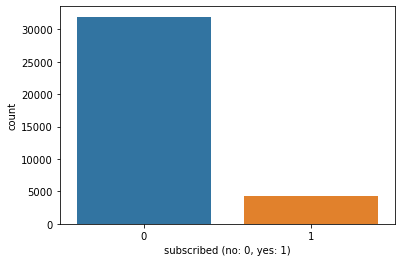

((36168, 16), (9043, 16))

In [7]:
# Particiones para evaluación
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('y', axis=1),  # predictors
    data['y'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

sns.countplot(x=y_train)
plt.xlabel('subscribed (no: 0, yes: 1)')

# Guardar la imagen con un tamaño más grande
plt.savefig('subscription_plot.png', dpi=300, bbox_inches='tight')
plt.show()

X_train.shape, X_test.shape

<div id="Desarrollo-metodos" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Desarrollo de métodos mediante Pipelines</h2> </div>

<div style="color:#106ba3"><h3>Pipeline de transformación para análisis de correlaciones</h3> </div>

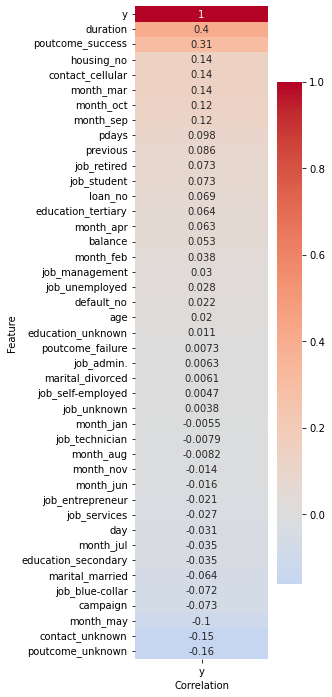

In [20]:
# set up the pipeline
pipeTransformation = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # add missing indicator to numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # scale
    ('scaler', StandardScaler())
])

# train the pipeline
pipeTransformation.fit(X_train, y_train)

# Transformar los datos
X_train_transformed = pipeTransformation.transform(X_train)

# Añadir la variable objetivo a los datos transformados
df_transformed = pd.DataFrame(X_train_transformed, columns=pipeTransformation.get_feature_names_out())
df_transformed['y'] = y_train.reset_index(drop=True)

# Calcular las correlaciones
correlations = df_transformed.corr()['y'].sort_values(ascending=False)

# Crear una figura de las correlaciones ordenadas
plt.figure(figsize=(3, 12))
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
#plt.title('Correlaciones Ordenadas con Respecto a la Variable de Estudio')
plt.xlabel('Correlation')
plt.ylabel('Feature')

# Guardar la figura en alta calidad
plt.savefig('correlations.png', dpi=300, bbox_inches='tight')

# Mostrar la figura
plt.show()

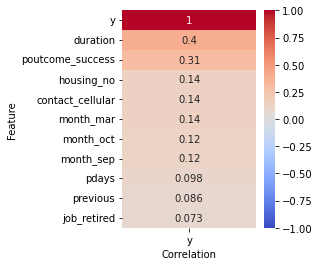

In [24]:
# Seleccionar las primeras 10 variables más correlacionadas positivamente
top_10_positive_correlations = correlations[correlations > 0].head(11)

# Crear una figura para las 10 variables más correlacionadas positivamente
plt.figure(figsize=(3, 4))
sns.heatmap(top_10_positive_correlations.to_frame(), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
#plt.title('Top 10 Variables más Correlacionadas Positivamente con Respecto a la Variable de Estudio')
plt.xlabel('Correlation')
plt.ylabel('Feature')

# Guardar la figura de las 10 variables más correlacionadas positivamente en alta calidad
plt.savefig('top_10_correlations.png', dpi=300, bbox_inches='tight')

# Mostrar la figura de las 10 variables más correlacionadas positivamente
plt.show()

<div style="color:#106ba3"><h3>Pipeline de método con el modelo: Regresión Logística</h3> </div>

In [81]:
# set up the pipeline
pipeLogisticRegression = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # add missing indicator to numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # scale
    ('scaler', StandardScaler()),

    ('Logit', LogisticRegression(C=0.0005, random_state=0)),
])

In [82]:
# train the pipeline
pipeLogisticRegression.fit(X_train, y_train)

Pipeline(steps=[('categorical_imputation',
                 CategoricalImputer(variables=['job', 'marital', 'education',
                                               'default', 'housing', 'loan',
                                               'contact', 'month',
                                               'poutcome'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['age', 'balance', 'day',
                                                'duration', 'campaign', 'pdays',
                                                'previous'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['age', 'balance', 'day',
                                              'duration', 'campaign', 'pdays',
                                              'previous'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['job', 'marital', 'education',
                                          'default', 'housing', 'loan',
                                          'contact', 'month', 'poutcome'])),
                ('scaler', StandardScaler()),
                ('Logit', LogisticRegression(C=0.0005, random_state=0))])

In [84]:
train_test_metrics(pipeLogisticRegression)    

Resultados en Train:
Accuracy: 0.8982
Precision: 0.8062
Recall o Sensitivity: 0.6039
F1-Score: 0.6401

Resultados en Test:
Accuracy: 0.8953
Precision: 0.7847
Recall o Sensitivity: 0.6027
F1-Score: 0.637


<div style="color:#106ba3"><h3>Pipeline de método con el modelo: K Nearest Neighbors (KNN)</h3> </div>

In [10]:
from sklearn.neighbors import KNeighborsClassifier
# set up the pipeline
pipeKNN = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # add missing indicator to numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # scale
    ('scaler', StandardScaler()),

    ('knn', KNeighborsClassifier(n_neighbors=5)),
])

In [11]:
# train the pipeline
pipeKNN.fit(X_train, y_train)
train_test_metrics(pipeKNN) 

Resultados en Train:
Accuracy: 0.9182
Precision: 0.8405
Recall o Sensitivity: 0.7147
F1-Score: 0.7584

Resultados en Test:
Accuracy: 0.8925
Precision: 0.7452
Recall o Sensitivity: 0.648
F1-Score: 0.6794


<div style="color:#106ba3"><h3>Pipeline de método con el modelo: Random Forest</h3> </div>

In [113]:
# set up the pipeline
pipeRF = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # add missing indicator to numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # scale
    ('scaler', StandardScaler()),

    ('rf', RandomForestClassifier(n_estimators= 200, max_features= 'log2', max_depth= 30, criterion='entropy', random_state=0)),
])

In [114]:
# train the pipeline
pipeRF.fit(X_train, y_train)
train_test_metrics(pipeRF) 

Resultados en Train:
Accuracy: 1.0
Precision: 1.0
Recall o Sensitivity: 1.0
F1-Score: 1.0

Resultados en Test:
Accuracy: 0.903
Precision: 0.7885
Recall o Sensitivity: 0.6707
F1-Score: 0.7087


<div id="Explicacion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Explicación de variables importantes</h2> </div>

In [134]:
# Obtener el nombre de las columnas después de la transformación
def get_feature_names(pipeline):
    # Extraer el transformador del paso de OneHotEncoder
    encoder = pipeline.named_steps['categorical_encoder']
    # Obtener nombres de las características transformadas
    feature_names = encoder.get_feature_names_out()
    
    # Nombres de las características de los datos numéricos
    numerical_features = []

    # Crear la lista final de nombres de características
    all_feature_names = numerical_features + feature_names
    
    return all_feature_names

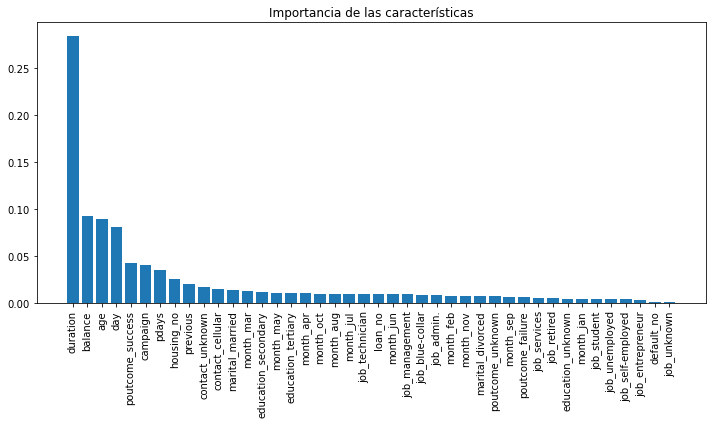

Características seleccionadas: ['duration' 'balance' 'age' 'day' 'poutcome_success' 'campaign' 'pdays'
 'housing_no' 'previous' 'contact_unknown']


In [159]:
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance

# Visualiza uno de los árboles del bosque
estimator = pipeRF.named_steps['rf'].estimators_[0]

# Exportar el árbol a un archivo dot
export_graphviz(estimator, out_file='tree.dot', 
                feature_names=pipeRF.named_steps['categorical_encoder'].get_feature_names_out(),
                class_names=[0, 1],
                rounded=True, proportion=False, 
                precision=2, filled=True)

# Para convertir el archivo .dot a una imagen .png
import os
os.system('dot -Tpng tree.dot -o tree.png')
print('Imagen de árbol creada')

# Obtener las importancias de las características

estimator = pipeRF.named_steps['rf']

importances = estimator.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir los nombres de las columnas después de la transformación
feature_names = get_feature_names(pipeRF)
features = pd.Index(feature_names)

# Visualizar las importancias de las características
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

# Seleccionar las N características más importantes (por ejemplo, las 10 más importantes)
N = 10
important_features = features[indices][:N]

# Mostrar las características seleccionadas
print("Características seleccionadas:", important_features.values)